Hello!

Up-to-date geographical data of the Dutch municipalities and neighbourhoods ("Wijk- en buurtkaart" can be retrieved from: https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data

You go Glen Coco!


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import lisualisation as lis
destination = "../layouts/partials/svgs/elan_map_raw.svg"

In [2]:
colours = ["#e70777", "#00b0f0", "#7030a0", "#9895BC", "#9895BC", "#9895BC", "#9895BC" ,"#9895BC"]

In [3]:
df = gpd.read_file("wijkbuurtkaart_2023_v1/gemeenten_2023_v1.shp")
df = df[df.H2O == "NEE"]
gemeentecodes = pd.read_excel("elan_classification.xlsx", sheet_name=None)

In [4]:
gemeentecodes["classification"]

,Naam,gm_code,class,comment
0,Noordwijk,GM0575,1,NaN
1,Katwijk,GM0537,1,NaN
2,Hillegom,GM0534,1,NaN
3,Lisse,GM0553,1,NaN
4,Teylingen,GM1525,1,NaN
5,Leiden,GM0546,1,NaN
6,Voorschoten,GM0626,1,NaN
7,Zoeterwoude,GM0638,1,NaN
8,Kraag en Braassem,GM1884,1,NaN
9,Alphen aan den Rijn,GM0484,1,NaN


Include sexy colors

In [5]:
def sexy_color_generator(amount):
    return ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(amount)]

gemeentecodes["classification"]["color"] = sexy_color_generator(gemeentecodes["classification"].shape[0])

Get geometries of ELAN municipalities

In [6]:
elan = gemeentecodes["classification"].merge(df, left_on="gm_code", right_on="GM_CODE")
elan = gpd.GeoDataFrame(elan)

Get geometries of province

In [7]:
provincedf = pd.read_excel("Gemeenten alfabetisch 2023.xlsx")
provincedf = provincedf[provincedf.ProvinciecodePV == "PV28"]
province = df[df.GM_CODE.isin(provincedf.GemeentecodeGM)]

Generate background

In [8]:
background = elan.dissolve(by='class', aggfunc = 'sum')
# background["color"] = background.index
# background["color"].replace(sexy_colors, inplace=True)
background["color"] = sexy_color_generator(background.shape[0])

Create visual

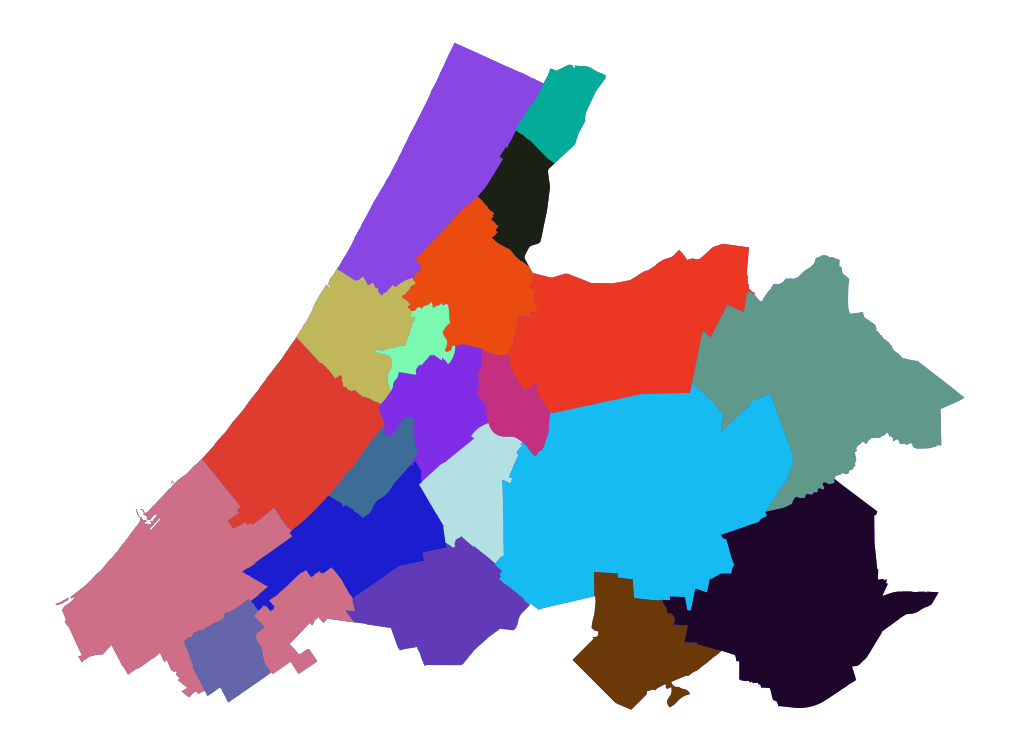

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

#province.plot(ax=ax, color='#ffffff', edgecolor='#001157', linewidth=1)
background.plot(ax=ax, color=background["color"], linewidth=0)
elan.plot(ax=ax, color=elan["color"], linewidth=0)

_=ax.axis('off')
#plt.show()
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig(destination, dpi=300, format="svg", transparent=True, bbox_inches= 'tight', pad_inches = 0)

Assign all the paths in the generated svg image the aprropriate class to enable interaction and animation. We use the colors to match up the geometry and the right class. We also include style attributes and make it interactive.

In [10]:
background["myclass"] = "region"+ background.index.astype(str)
elan["myclass"] = elan.Naam
combi_df = pd.concat([background, elan])

In [11]:
css= r'''
    .category1, .region1{
        fill: #e70777;
    }
    
    .category2, .region2{
        fill: #00b0f0;
    }

    .category3, .region3{
        fill: #7030a0;
    }

    svg{
        font-family: "Open Sans", sans-serif;
        font-size: 30px;
    }

    .circle_stat{
        transform-box: fill-box;
        transform-origin: center;
        transform: rotate(-90deg);
    }

    .stat_title{
        font-weight: bold;
        fill: #786ebd;
    }
    
    .category1:hover, .category2:hover, .category3:hover{
        filter: brightness(1.25);
    }

    .hover_text{
        font-size: 1.1em;
        fill: #000000;
        font-weight: 600;
        pointer-events: none;
    }

    .hover_container_hidden{
        display: none;
    }
    '''

`//<![CDATA[` and `//]]>` are required since that allows for proper parsing

In [12]:
js = r"""
<script type="text/javascript">   
//<![CDATA[    
    const cat_names = ["1", "2", "3"];
    const cats = cat_names.map(cat => document.getElementsByClassName("category" + cat));
    const regs = document.getElementById("hover_container");
    const hovers = document.getElementById("hover_text");

    for(let j = 0; j < cat_names.length; j++) {
        for(let i = 0; i < cats[j].length; i++) {
            cats[j][i].onmouseleave = function(){
                regs.classList.add('hover_container_hidden');
                hovers.textContent = '';
            };
            
            cats[j][i].onmouseover = function(){
                hovers.textContent = cats[j][i].getAttribute('data-name');
                regs[j].classList.remove('hover_container_hidden');
                bbox = cats[j][i].getBBox();
                hovers.setAttribute('x', bbox.x + bbox.width/2 );
                hovers.setAttribute('y', bbox.y + bbox.height/2);
            };
        };
    };    
        
    //]]>
</script>   
"""

Hoverinfo for les regions

In [13]:
stats = gemeentecodes["stats"]
stats_2024 = stats[stats["year"] == 2024].copy()

In [14]:
practices = stats_2024.sort_values("region")["practices"].tolist()
patients = stats_2024.sort_values("region")["patients"].tolist()

In [15]:
hover_regions ="<g>"
#pink, blue, purple
x = [410, 315, 385]
y = [90, 300, 420]
hover_width = 720
x_text_l_margin = 5
hover_height = 80

hover_regions += rf'''
    <g id="hover_container" class="hover_container_hidden">
        <text id="hover_text" class="hover_text" x="410" y="90" text-anchor="left"></text>
    </g>
'''
hover_regions += "</g>"

In [18]:
with open(destination, 'r') as file:
    # read a list of lines into data
    lines = file.readlines()

lines = lines[3:]

lines[0] = '''<svg id="elan_map" xmlns:xlink="http://www.w3.org/1999/xlink" class="{{ .class }}" viewBox="0 0 720 528.173872" xmlns="http://www.w3.org/2000/svg" version="1.1">'''

munic_colors = elan["color"].tolist()

for i in range(0, len(lines)):
    line = lines[i]
    if ("fill" in line) and ("path" in line):
        line_split = line.split('style="fill: ', 1)
        color = line_split[1][:7].upper()
        entry = combi_df[combi_df.color == color]
        my_class = entry["myclass"].item()
        if color in munic_colors:
            #class holds a lot of classes, data-name is the name of the municipality
            my_class += " municipality category" + str(int(entry["class"].item())) + '" data-name="' + my_class
        lines[i] = line_split[0] + 'class="' + my_class + '"/>'
    elif "</style>" in line: #add css
        line_split = line.split('</style>', 1)
        lines[i] = line_split[0] + css + "</style>"
    elif "</svg>" in line: # add hover feature
        # lines[i] = hover_regions + js + line
        lines[i] = hover_regions + line

with open("../layouts/partials/svgs/elan_map.svg", 'w') as file:
    file.writelines(lines)

to generate circles

In [ ]:
lis.make_sexy_circle(stats_2024["patients"].tolist(), colours, "../layouts/partials/svgs/patients.svg")
lis.make_sexy_circle(stats_2024["practices"].tolist(), colours, "../layouts/partials/svgs/practices.svg")